In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge

from sklearn.ensemble import RandomForestRegressor
import math
import random as rnd

In [86]:
# READING FILE
curr_dir = os.getcwd() 
dir_name = curr_dir + "\\NYC_Airbnb"
dev_file_name = "development.csv"
df = pd.read_csv(dir_name + "\\" + dev_file_name)
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,12783632,NYC Mini Hotel,57230304,Imanuelly,Queens,Elmhurst,40.74037,-73.88610,Private room,75,1,2,2019-05-26,0.92,3,351
1,3463385,Gorgeous room in Manhattan,10698270,Evgenia,Manhattan,Upper East Side,40.76717,-73.95532,Private room,95,1,202,2019-05-27,3.31,2,263
2,17572926,Great 1 Bedroom on Upper East,36578169,James,Manhattan,Upper East Side,40.77984,-73.94725,Entire home/apt,130,2,0,NaN,NaN,1,0
3,33913644,"Modern and bright 2Bed 2Bath Bushwick, Brooklyn",50981314,Ofier,Brooklyn,Bushwick,40.70205,-73.91338,Entire home/apt,150,2,4,2019-07-07,1.64,1,89
4,9405895,Stylish and zen Brooklyn retreat,48775347,Mathieu,Brooklyn,Fort Greene,40.68914,-73.97853,Entire home/apt,325,3,16,2019-04-20,0.42,1,103


In [6]:
# ANALYZING DATA
def analyze_data(df): 

    grouped_df = df.groupby(['neighbourhood_group','room_type'])

    for key, group in grouped_df:
        
        prices = group['price']

        avg_price = prices.mean()
        max_price = prices.max()
        min_price = prices.min()
        std_price = prices.std()
        print(f"{key}:\n\tn_samples:{len(group)}\n\tmean:{avg_price}\n\tstd:{std_price}\n\tmax:{max_price}\n\tmin:{min_price}")

In [72]:
# filtering 
def filter_data(df):
    price_mask = (df['price'] != 0)
    review_mask = (df['number_of_reviews'] != 0)
    availab_mask = (df['availability_365'] != 0)
    filtered_df = df[price_mask & availab_mask]
#     grouped_df = filtered_df.groupby(['neighbourhood','room_type'])

#     ids_to_keep = []
#     for key, group in grouped_df:

#         prices = group['price']
#         avg_price = prices.mean()
#         std_price = prices.std()
        
#         if(math.isnan(std_price)):
#             std_price = 0
        
#         mask = ((group['price'] <= avg_price + 2*std_price) & (group['price'] >= avg_price - 2*std_price))
#         for idf in list(group[mask]['id']):
#             ids_to_keep.append(idf)
     
#     filter_mask = ([e in ids_to_keep for e in filtered_df['id']])
#     filtered_df = filtered_df[filter_mask]
    
    return filtered_df

In [8]:
def normalize_df(df):
    return (df-df.min())/(df.max()-df.min())

In [76]:
def feature_selection_extraction(df):
    attributes = ['latitude', 'longitude', 'room_type']
    df = df[attributes]
    df = pd.get_dummies(df, columns=['room_type'], drop_first=False)
    return df

In [114]:
def scatter_plot_2d(lat,long,prices):
    fig,ax = plt.subplots(figsize=(15,15))
    plt.xlabel('latitude')
    plt.ylabel('longitude')
    plt.scatter(lat,long,c=prices, vmin = 0, vmax = 200, s= 3)

In [11]:
def room_type_dist(df):
    for nb_group in df['neighbourhood_group'].unique():
        specific_df = df[df['neighbourhood_group'] == nb_group]
        plt.subplots()
        plt.title(nb_group)
        plt.hist(specific_df['room_type'])

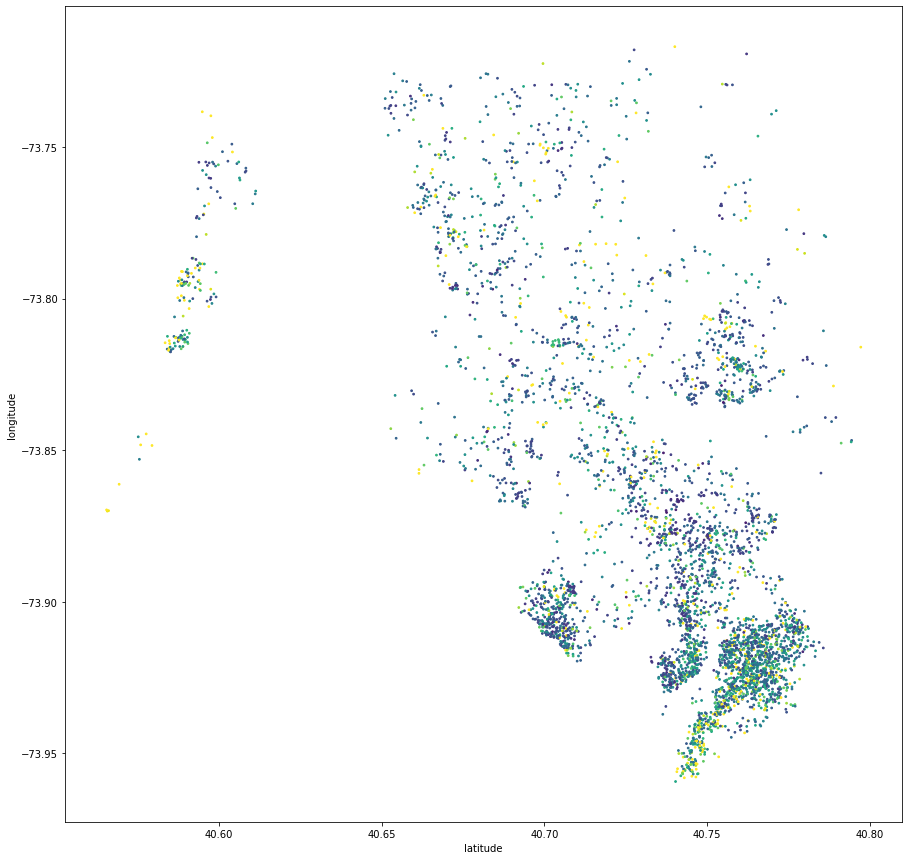

In [116]:
m_df = df[df['neighbourhood_group'] == 'Queens']
scatter_plot_2d(m_df['latitude'], m_df['longitude'], m_df['price'])

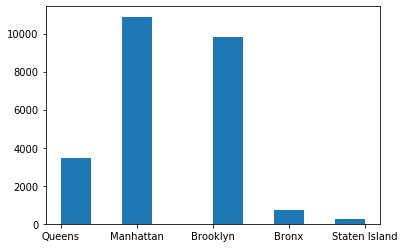

In [73]:
df = filter_data(df)
plt.hist(df['neighbourhood_group'])
samples_per_category = min(df.groupby('neighbourhood_group')['id'].nunique())

In [59]:
grouped_df = df.groupby('neighbourhood_group')

ids_to_keep = []
for key, group in grouped_df:
    extracted = rnd.sample(range(0, len(group)), min([samples_per_category,len(group)]))
    ids = group.iloc[extracted]['id']
    for e in ids:
        ids_to_keep.append(e)

mask = [e in ids_to_keep for e in df['id']]
new_df = df[mask]        

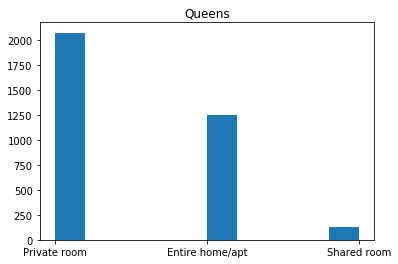

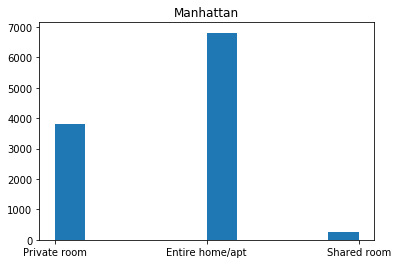

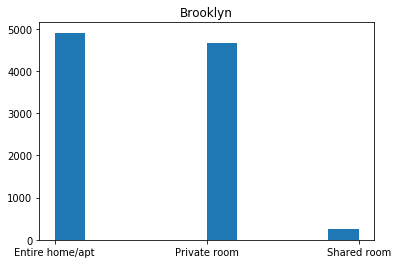

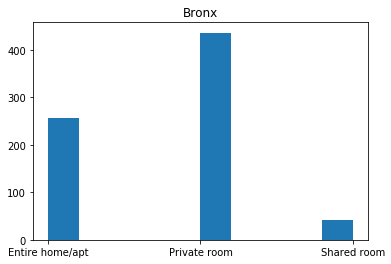

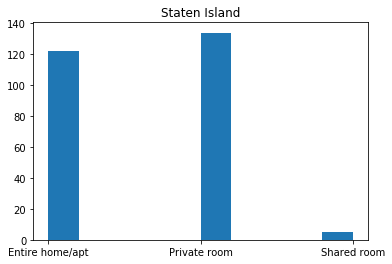

In [74]:
new_df = df
room_type_dist(new_df)

In [77]:
X_df = feature_selection_extraction(new_df)

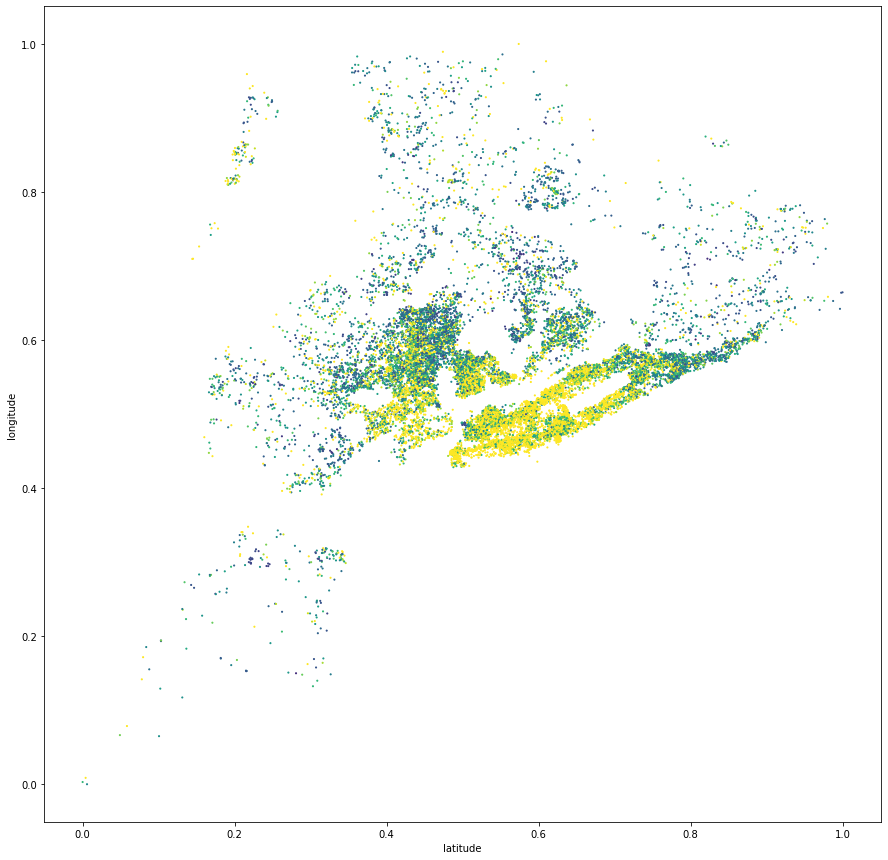

In [78]:
y = new_df['price']
X = normalize_df(X_df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)
scatter_plot_2d(X_train['latitude'], X_train['longitude'], y_train)

In [79]:
reg = RandomForestRegressor()
param_grid = {'n_estimators':[120,140,160,180], 'max_depth': [6,8,10,None], 'random_state':[42], 'n_jobs':[-1]}
search = GridSearchCV(reg, param_grid, scoring='r2', cv=5)
res = search.fit(X_train,y_train)
print(res.best_params_)
print(res.best_score_)

{'max_depth': 6, 'n_estimators': 120, 'n_jobs': -1, 'random_state': 42}
0.09374819964509093


In [83]:
reg = make_pipeline(PolynomialFeatures(), Lasso(max_iter=800))
param_grid = {'polynomialfeatures__degree': [1,2,3], 'lasso__alpha':[0.1,0.3,0.5,1]}
search = GridSearchCV(reg, param_grid, scoring='r2', cv=5)
res = search.fit(X_train,y_train)
print(res.best_params_)
print(res.best_score_)

c:\users\fratt\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 447665.8271842003, tolerance: 108824.75966382006
  positive)


{'lasso__alpha': 0.1, 'polynomialfeatures__degree': 3}
0.09081762479742413


R2 (test set): 0.10


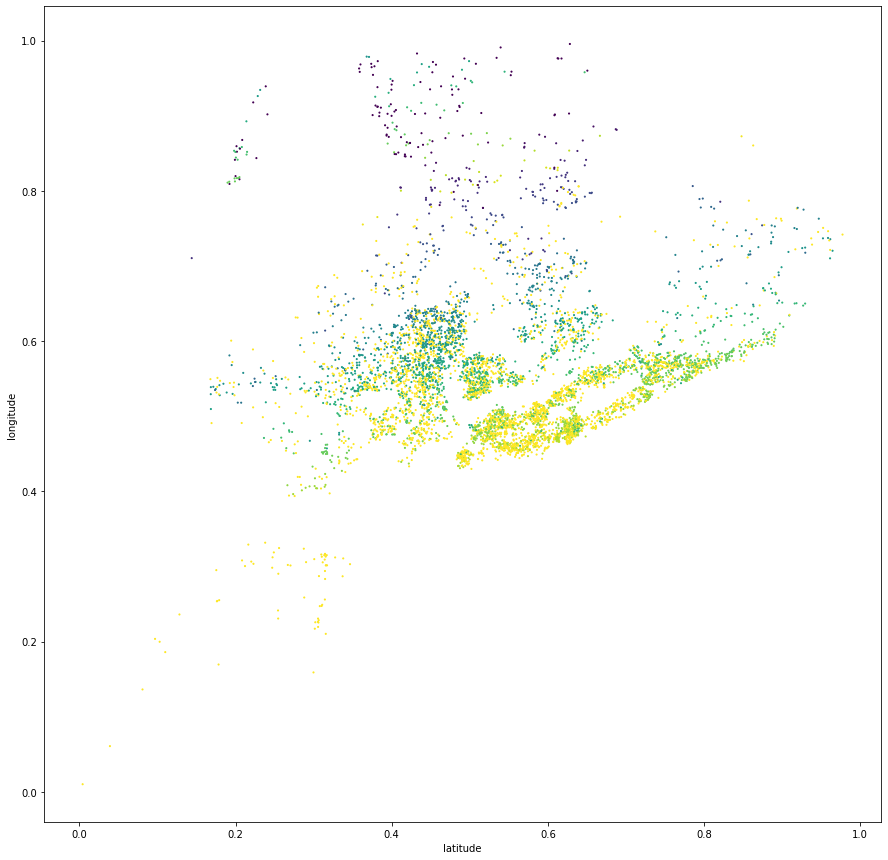

In [85]:
# final_model = res.best_estimator_
final_model = LinearRegression()
final_model.fit(X_train, y_train)

y_test_pred = final_model.predict(X_test)

r2 = r2_score(y_test, y_test_pred)
print("R2 (test set): %.2f" % r2)
scatter_plot_2d(X_test['latitude'],X_test['longitude'] , y_test_pred)

In [81]:
eval_file_name = "evaluation.csv"
eval_df = pd.read_csv(dir_name + "\\" + eval_file_name)
ids = eval_df['id']
X_eval = feature_selection_extraction(eval_df)
X_eval = normalize_df(X_eval)

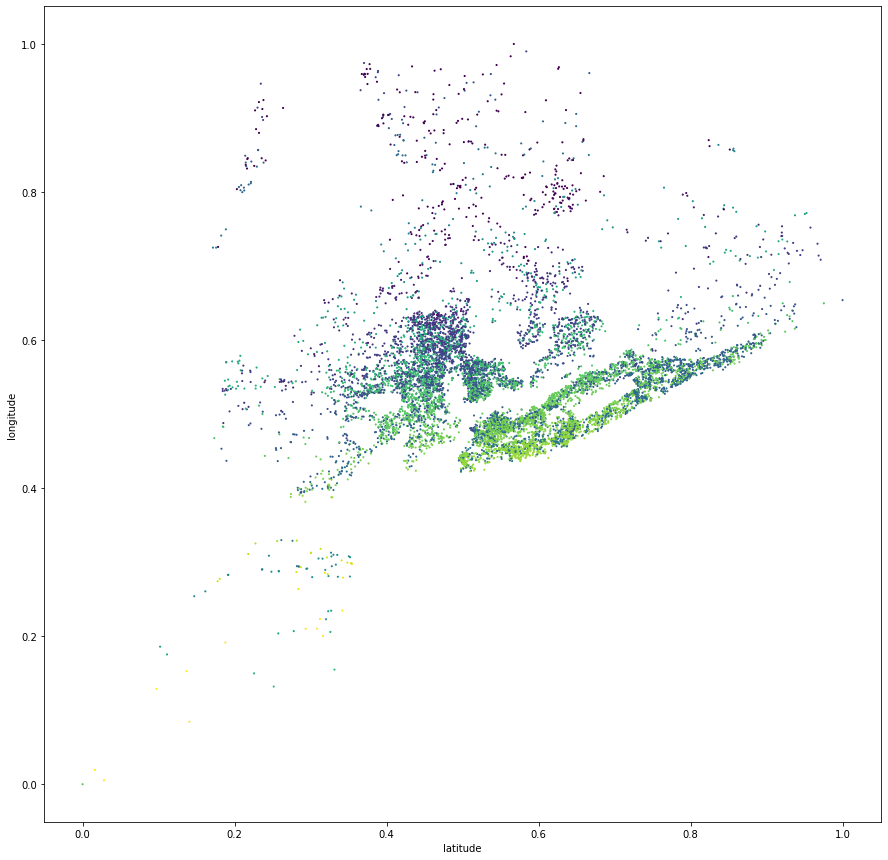

In [92]:
y_pred = final_model.predict(X_eval)
scatter_plot_2d(X_eval['latitude'],X_eval['longitude'] , y_pred)
pred_df = pd.DataFrame({'Id':ids,'Predicted': y_pred})
pred_df.loc[(pred_df['Predicted']<0),'Predicted'] = 0
pred_df.to_csv("predictions.csv", index=False)